# Step 1 - Model Selection

We started from the work done in the preprocessing. We have fixed the number of dimension to be used with the reduction to 100, this seemed a good compromise between speed and variance explanation (see preprocessing notebook). <br>
For computational ease we reduce the usage of the dataset to a little fraction, the entire dataset will be used to predict the "unseen" data later. <br>
To proceed with the exercise we need to do the preprocessing again, so we put it here in one piece of code:


In [1]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/amazon_step1.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'category','reviewText']])
df = df.ix[:2000,:]
del df_complete

# Group comments by product and category assigned
united = df.groupby(['asin', 'category'])['reviewText'].apply(' '.join).reset_index()

old = 0

product_numbers = []

# create the list of the products with more than one category assigned
for _,row in united.iterrows():
    
    if(old == row['asin']):
        
        product_numbers.append(row['asin'])
        
    old = row['asin']

    
indexes=[]

# find what are the comments related to the products found above
for i,df_row in df.iterrows():
    
    if df_row['asin'] in product_numbers:
        
        indexes.append(i)

# drop the ambiguous observations
df.drop(df.index[[indexes]], inplace = True)

# All the special characters were removed from the sample
df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    

from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS

documents = df_refined

# remove the stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

lemmatizer = WordNetLemmatizer()

documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

# remove non-english words
import enchant
eng_dic = enchant.Dict("en_US")

documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)

# convert the corpus into bag of words 
from gensim import models, corpora, matutils
dictionary = corpora.Dictionary(ready_corpus)

corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

from sklearn.model_selection import train_test_split
train_tfidf, test_tfidf, train_category, test_category = train_test_split(sparse_corpus_tfidf_transpose, df.ix[:,1], test_size = 0.2, random_state = seed)


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Now we proceed reducing the dimensions, we used a Kernel PCA with cosine distance that is ideal for managing text data in a tfidf form.

In [2]:
print('Starting dimensionality reduction')

# reduce dimensions
from sklearn.decomposition import KernelPCA

reducer= KernelPCA(n_components = 100, kernel="cosine", random_state=seed)
corpus_train_tfidf_kpca = reducer.fit_transform(train_tfidf)
corpus_test_tfidf_kpca = reducer.transform(test_tfidf)

print('Finished dimensionality reduction')

Starting dimensionality reduction
Finished dimensionality reduction


First of all we create a Baseline classifier that will help us providing a benchmark to our forecasts

In [3]:
from sklearn.dummy import DummyClassifier

X_train = corpus_train_tfidf_kpca 
X_test = corpus_test_tfidf_kpca
y_train = train_category
y_test = test_category

dummy_clf = DummyClassifier(strategy='stratified', random_state = seed)
dummy_clf.fit(X_train, y_train)

print('Dummy Classifier Test Performance:', dummy_clf.score(X_test,y_test))

Dummy Classifier Test Performance: 0.045


Not surprisingly the dummy classifier has an accuracy score that is close to 1/24 = 0.0416. <br>
The first model we propose is a simple KNN classifier. The model is optimized through a pipeline in a Gridsearch CV. The pipeline is used to include Normalization that is fundamental to compute distances properly:

Starting Grid Search


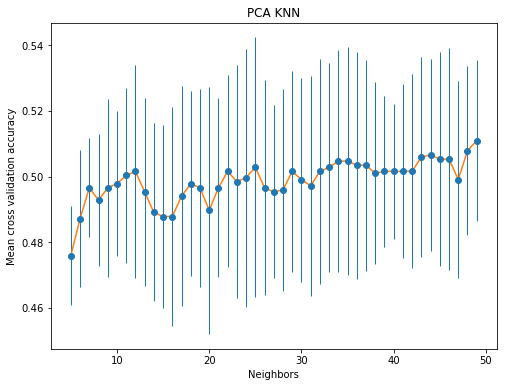

Best Number of Neighbors: 49

Test score for Optimized KNN: 0.51


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier


X_train = corpus_train_tfidf_kpca 
X_test = corpus_test_tfidf_kpca
y_train = train_category
y_test = test_category

#Initialize K-Fold for cross validation
K = 5
kfold = KFold(n_splits=K, random_state=seed)

#Create Pipeline
estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('knn_clf', KNeighborsClassifier()))
reg_knn_pipe1 = Pipeline(estimators)
reg_knn_pipe1.set_params(knn_clf__algorithm='ball_tree',knn_clf__weights='uniform')

#Create a grid search over n_neighbors values
parameters = {
        'knn_clf__n_neighbors' : np.arange(5,50)
}
estimator_knnreg = GridSearchCV(reg_knn_pipe1, parameters, cv=kfold)
                  
#Evaluate the grid search and print best regressor
print('Starting Grid Search')
estimator_knnreg.fit(X_train, y_train)

alphas = [x['knn_clf__n_neighbors'] for x in estimator_knnreg.cv_results_['params']]
means = [x for x in estimator_knnreg.cv_results_['mean_test_score']]
stds = [x for x in estimator_knnreg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('Neighbors')
plt.ylabel('Mean cross validation accuracy')
plt.title('PCA KNN')
plt.show()

reg_knn_pipe1.set_params(knn_clf__n_neighbors = estimator_knnreg.best_params_['knn_clf__n_neighbors'])
reg_knn_pipe1.fit(X_train, y_train)

print("Best Number of Neighbors:", estimator_knnreg.best_params_['knn_clf__n_neighbors'])
print ('\nTest score for Optimized KNN:', reg_knn_pipe1.score(X_test,y_test))



The result is definitely better, but not striking, moreover it is subject to high variance. Let's try with some trees. <br>
We will not use a Boosted tree since it is too sensible to noisy data and to slow to run (in the test we ran we also noticed that the performance was not good). We propose a standard tree classifier and a Bagged tree (random forest didn't have superior performance but required much more computational time).

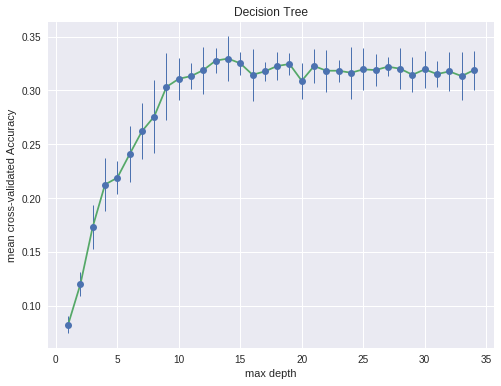


Best max depth --->    14

Test score --->    0.37

Feature importances:



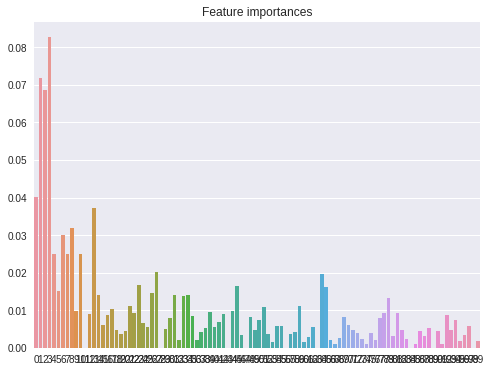


Bagging Test score --->    0.475


In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import seaborn as sns



K = 5
kfold = KFold(n_splits=K, random_state=seed)


n_tried=35
depths=np.arange(1,n_tried)

estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('tree_cla', tree.DecisionTreeClassifier(random_state=seed)))
cla_tree_pipe1 = Pipeline(estimators)

parameters = {
        'tree_cla__max_depth' : depths
}
estimator_treecla = GridSearchCV(cla_tree_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_treecla.fit(X_train, y_train)

alphas = [x['tree_cla__max_depth'] for x in estimator_treecla.cv_results_['params']]
means = [x for x in estimator_treecla.cv_results_['mean_test_score']]
stds = [x for x in estimator_treecla.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('max depth')
plt.ylabel('mean cross-validated Accuracy')
plt.title('Decision Tree')
plt.show()

print('\nBest max depth --->   ',estimator_treecla.best_params_['tree_cla__max_depth'])

cla_tree_pipe1.set_params(tree_cla__max_depth = estimator_treecla.best_params_['tree_cla__max_depth'])
cla_tree_pipe1.fit(X_train, y_train)
acc_b = cla_tree_pipe1.score(X_test, y_test)
print ('\nTest score --->   ', acc_b)
print ('\nFeature importances:\n')
importances = cla_tree_pipe1.named_steps['tree_cla'].feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
sns.barplot(indices, y=importances[indices])
plt.show()


estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('bag_cla', BaggingClassifier()))
cla_bag_pipe1 = Pipeline(estimators)
cla_bag_pipe1.set_params(bag_cla__base_estimator=tree.DecisionTreeClassifier(max_depth=estimator_treecla.best_params_['tree_cla__max_depth']),\
                         bag_cla__n_estimators=500, bag_cla__random_state=seed)

cla_bag_pipe1.fit(X_train,y_train)
acc_c=cla_bag_pipe1.score(X_test, y_test)
print ('\nBagging Test score --->   ', acc_c)


The results are not as good as the KNN, probably due to the highly irregular shape  and distribution of the clusters. We see that the noisyness of the data makes the Bagging classifier much better than the basic decision tree. <br>
We have taken the opportunity to analyze feature importances, we noticed that these are mostly different from zero and there are no huge differences among them. This is a confirmation that dimensionality reduction is a critical problem in this context. <br>
Last but not least we move to parametric models, with some SVMs and a Logistic Regression:

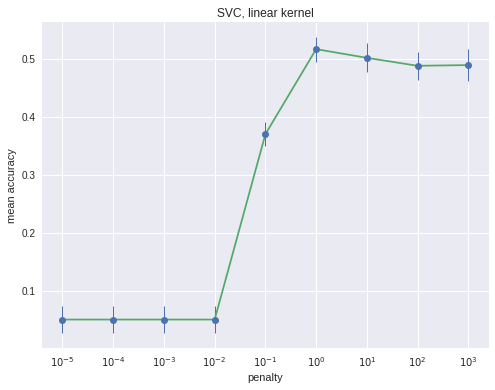


Best penalty for linear kernel --->    1.0

Linear kernel test score --->    0.5475


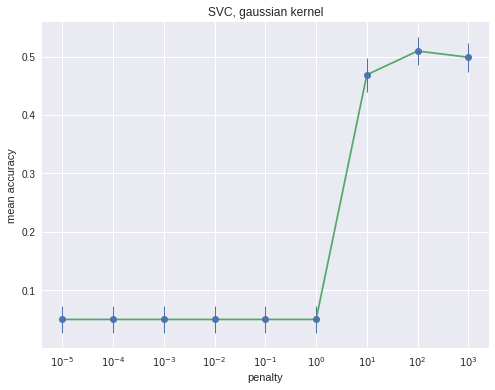


Best penalty for Gaussian kernel --->    100.0

Test score --->    0.52


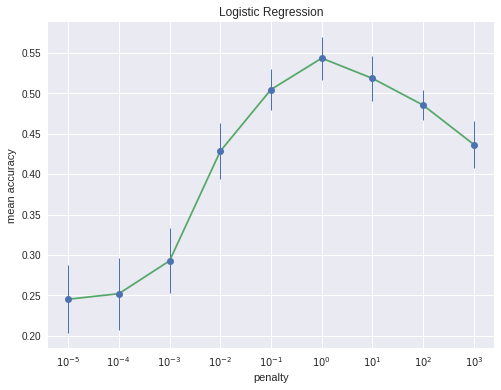


Best penalty for Logistic Regression --->    1.0

Logistic regression test score --->    0.56


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
                  


K = 5
kfold = KFold(n_splits=K, random_state=seed)

# LINEAR KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_linear_clf', SVC()))
svm_linear_pipe1 = Pipeline(estimators)
svm_linear_pipe1.set_params(svm_linear_clf__kernel='linear', svm_linear_clf__gamma='auto')

penalties = np.logspace(-5,3,9)


parameters = {
        'svm_linear_clf__C' : penalties
}
estimator_svm_linear = GridSearchCV(svm_linear_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_linear.fit(X_train,y_train)

alphas = [x['svm_linear_clf__C'] for x in estimator_svm_linear.cv_results_['params']]
means = [x for x in estimator_svm_linear.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_linear.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('SVC, linear kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for linear kernel --->   ',estimator_svm_linear.best_params_['svm_linear_clf__C'])

svm_linear_pipe1.set_params(svm_linear_clf__C = estimator_svm_linear.best_params_['svm_linear_clf__C'])
svm_linear_pipe1.fit(X_train,y_train)
accuracy_b = svm_linear_pipe1.score(X_test,y_test)
print ('\nLinear kernel test score --->   ', accuracy_b)



# GAUSSIAN KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_gaussian_clf', SVC()))
svm_gaussian_pipe1 = Pipeline(estimators)
#No gridsearch on gamma, since 'auto' gave best results
svm_gaussian_pipe1.set_params(svm_gaussian_clf__kernel='rbf', svm_gaussian_clf__gamma='auto')

penalties = np.logspace(-5,3,9)


parameters = {
        'svm_gaussian_clf__C' : penalties
}
estimator_svm_gaussian = GridSearchCV(svm_gaussian_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_gaussian.fit(X_train,y_train)

alphas = [x['svm_gaussian_clf__C'] for x in estimator_svm_gaussian.cv_results_['params']]
means = [x for x in estimator_svm_gaussian.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_gaussian.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('SVC, gaussian kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for Gaussian kernel --->   ',estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])

svm_gaussian_pipe1.set_params(svm_gaussian_clf__C = estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])
svm_gaussian_pipe1.fit(X_train,y_train)
accuracy_b = svm_gaussian_pipe1.score(X_test,y_test)
print ('\nTest score --->   ', accuracy_b)



# LOGISTIC REGRESSION
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression()))
log_reg_pipe1 = Pipeline(estimators)
log_reg_pipe1.set_params()

penalties = np.logspace(-5,3,9)


parameters = {
        'log_reg__C' : penalties
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['log_reg__C'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('Logistic Regression')
plt.xscale('log')
plt.show()

print('\nBest penalty for Logistic Regression --->   ',estimator_log_reg.best_params_['log_reg__C'])

log_reg_pipe1.set_params(log_reg__C = estimator_log_reg.best_params_['log_reg__C'])
log_reg_pipe1.fit(X_train,y_train)
accuracy_c = log_reg_pipe1.score(X_test,y_test)
print ('\nLogistic regression test score --->   ', accuracy_c)

We can see that parametric models are the clear winner for this specific task with a good performance. Surprisingly linear models outperform non-linear models (by a few points). This is probably due to the noisy nature of the data. An interesting insight can be given looking at the confusion matrix of the best performer: the Logistic Regression

Confusion matrix, without normalization


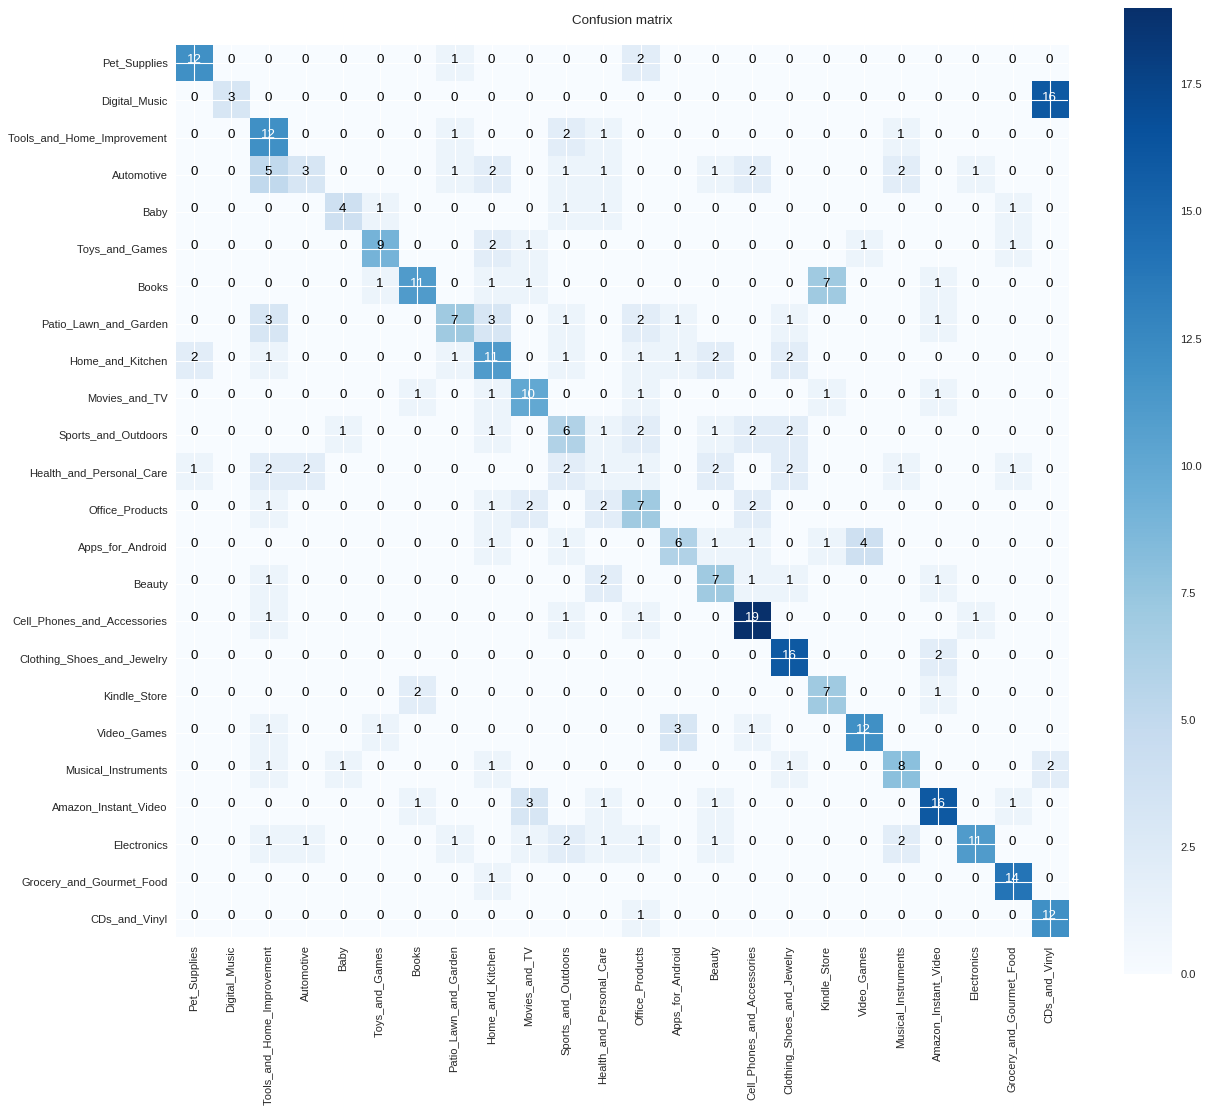

In [7]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



y_cap = log_reg_pipe1.predict(X_test)

Labels=train_category.unique()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_category, y_cap, labels=Labels)

# Plot confusion matrix
#plt.figure(2)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plot_confusion_matrix(cnf_matrix,Labels, normalize=False,
                      title='Confusion matrix\n')

plt.show()


What we notice is that the model correctly predicts a good proportiom of the data, but some categories are confused with others. This specfically happens for "Kindle" and "Books", "Digital music" and "CDs" and at last "Apps for Android" and "Video Games". This is not surprising for two reasons: one is that semantically speaking these categories are actually hard to distinguish (we actually tried doing this by reading some of the samples from these categories and it was very hard in some points to understand which sample belonged to which category). On the other hand these categories are those that where most close one to another in the 3D visualization we showed in preprocessing phase, in particular these classes constituted the long structures that were characteristic of that plot. 

To improve the performance of our models at this point some things could really help, these are: <br>
1) Use a better dimensionality reduction technique (We tried LDA and TSNE but didn't work that well, the latter     especially didn't allow us to use more than 4 dimensions). This could allow to better separate the data clusters. <br>
2)  Increase the computational power, or in other words, have a better CPU with possibility to parallelize jobs and use more data to fit the models and make predictions.<br>
<br>
To illustrate the effect of the second point we plot a learning curve for the logistic regression (we have to do the preprocessing again with more data, for ease of computation we will only use 20'000 comments):

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Finished Preprocessing
Computing Learning Curve


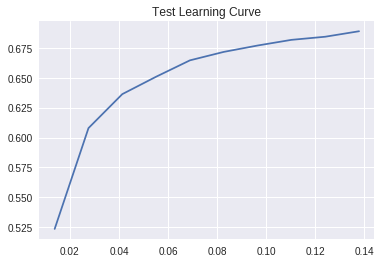

In [8]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/amazon_step1.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'category','reviewText']])
df = df.ix[:20000,:]
del df_complete

# Group comments by product and category assigned
united = df.groupby(['asin', 'category'])['reviewText'].apply(' '.join).reset_index()

old = 0

product_numbers = []

# create the list of the products with more than one category assigned
for _,row in united.iterrows():
    
    if(old == row['asin']):
        
        product_numbers.append(row['asin'])
        
    old = row['asin']

    
indexes=[]

# find what are the comments related to the products found above
for i,df_row in df.iterrows():
    
    if df_row['asin'] in product_numbers:
        
        indexes.append(i)

# drop the ambiguous observations
df.drop(df.index[[indexes]], inplace = True)

# All the special characters were removed from the sample
df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    

from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS

documents = df_refined

# remove the stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

lemmatizer = WordNetLemmatizer()

documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

# remove non-english words
import enchant
eng_dic = enchant.Dict("en_US")

documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)

# convert the corpus into bag of words 
from gensim import models, corpora, matutils
dictionary = corpora.Dictionary(ready_corpus)

corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

print("Finished Preprocessing")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

#Initialize Logistic Regression
log_reg = LogisticRegression(C=1.0)


#Compute and Plot learning curve
print("Computing Learning Curve")
train_sizes, train_scores, test_scores = learning_curve(log_reg, sparse_corpus_tfidf_transpose, df.ix[:,1], train_sizes = np.linspace(0.1,1,10), cv=3)

plt.plot(train_sizes/96000, test_scores.mean(axis=1))
plt.title("Test Learning Curve")

We can see that the curve is upward sloping, but another interesting aspect is that with 14% of the data used the curve is still quite steep. This is actually a confirmation that we need to use as much data as we can to improve the model performance.<br>
At this point we wanted to see if 100 principal components was indeed the best reduction.

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Dictionary(7695 unique tokens: ['caliber', 'ammo', 'largely', 'sum', 'getting']...)


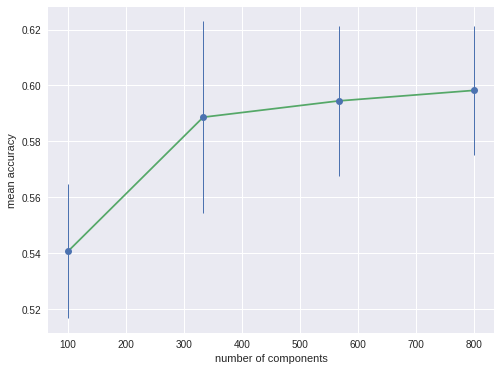


Best number of components --->    800.0

Logistic regression test score --->    0.616666666667


In [9]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/amazon_step1.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'category','reviewText']])
df = df.ix[:3000,:]
del df_complete

# Group comments by product and category assigned
united = df.groupby(['asin', 'category'])['reviewText'].apply(' '.join).reset_index()

old = 0

product_numbers = []

# create the list of the products with more than one category assigned
for _,row in united.iterrows():
    
    if(old == row['asin']):
        
        product_numbers.append(row['asin'])
        
    old = row['asin']

    
indexes=[]

# find what are the comments related to the products found above
for i,df_row in df.iterrows():
    
    if df_row['asin'] in product_numbers:
        
        indexes.append(i)

# drop the ambiguous observations
df.drop(df.index[[indexes]], inplace = True)

# All the special characters were removed from the sample
df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))
    

from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS

documents = df_refined

# remove the stopwords
documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop

# remove all numerics and tokens with numbers
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique

# lemmattizing tokens (better than stemming by taking word context into account)
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

lemmatizer = WordNetLemmatizer()

documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

# remove non-english words
import enchant
eng_dic = enchant.Dict("en_US")

documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

del documents_no_stop_no_unique_no_numeric_lemmatize

# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english

# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)

# convert the corpus into bag of words 
from gensim import models, corpora, matutils
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)

corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]

# convert to a sparse and compatible format
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sparse_corpus_tfidf_transpose, df.ix[:,1], test_size = 0.2, random_state = seed)


from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import KFold

%matplotlib inline


#Initialize K-Fold for cross validation
K = 5
kfold = KFold(n_splits=K, random_state=seed)

#%%
# LOGISTIC REGRESSION
estimators = []
estimators.append(('reducer', KernelPCA(kernel="cosine", random_state=seed)))
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression(C=1.0)))
log_reg_pipe1 = Pipeline(estimators)
log_reg_pipe1.set_params()

components = np.round(np.linspace(100,800,4))


parameters = {
        'reducer__n_components' : components
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['reducer__n_components'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('number of components')
plt.ylabel('mean accuracy')
plt.show()

print('\nBest number of components --->   ',estimator_log_reg.best_params_['reducer__n_components'])

log_reg_pipe1.set_params(reducer__n_components = estimator_log_reg.best_params_['reducer__n_components'])
log_reg_pipe1.fit(X_train,y_train)
accuracy_c = log_reg_pipe1.score(X_test,y_test)
print ('\nLogistic regression test score --->   ', accuracy_c)

It is clear that 100 was not the best choice, with a higher number of dimensions the other methods are quite slow and the logistic regression is still the best considering our computational power. We also noticed that the best number of principal components increases with the amount of data we use. When we are considering all the data our computers are not able to compute the principal components analysis, so we had to decide either to remove the dimensionality reduction from our model or to use a smaller sample. Considering the last results we decided to go with the first option.